<a href="https://colab.research.google.com/github/nitinfaye/YouTube-search/blob/main/YouTube_SearcherUsing_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Natural Language YouTube Searcher</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [CLIP](https://github.com/openai/CLIP)

Article: [Learning Transferable Visual Models From Natural Language Supervision](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)

Creator: **[OpenAI](https://openai.com/)**



<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@-nitinfaye](https://github.com/tg-bomze),
Telegram: [@-nitinfaye](https://t.me/nitinfaye).


---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```

In [ ]:
# Dashcam video of driving around San Francisco
video_url = "https://www.youtube.com/watch?v=PGMu_Z89Ao8" #@param {type:'string'}   

# How much frames to skip
N = 120


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
# pytube is used to download videos from YouTube
!pip install pytube

# Intall a newer version of plotly
!pip install plotly==4.14.3

# Install CLIP from the GitHub repo
!pip install git+https://github.com/openai/CLIP.git

# Install torch 1.7.1 with GPU support
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cf6lr9yl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cf6lr9yl
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download the video and process with CLIP</font></b>
from pytube import YouTube

# Choose a video stream with resolution of 360p
streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="360p", only_video=True)

# Check if there is a valid stream
if len(streams) == 0:
  raise "No suitable stream found for this YouTube video!"

# Download the video as video.mp4
print("Downloading...")
streams[0].download(filename="video.mp4")
print("Download completed.")

Downloading...
Download completed.


In [ ]:
import cv2
from PIL import Image

# The frame images will be stored in video_frames
video_frames = []

# Open the video file
capture = cv2.VideoCapture('video.mp4')
fps = capture.get(cv2.CAP_PROP_FPS)

current_frame = 0
while capture.isOpened():
  # Read the current frame
  ret, frame = capture.read()

  # Convert it to a PIL image (required for CLIP) and store it
  if ret == True:
    video_frames.append(Image.fromarray(frame[:, :, ::-1]))
  else:
    break

  # Skip N frames
  current_frame += N
  capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

# Print some statistics
print(f"Frames extracted: {len(video_frames)}")

Frames extracted: 962


In [ ]:
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
     

In [ ]:

import math
import numpy as np
import torch

# You can try tuning the batch size for very large videos, but it should usually be OK
batch_size = 256
batches = math.ceil(len(video_frames) / batch_size)

# The encoded features will bs stored in video_features
video_features = torch.empty([0, 512], dtype=torch.float16).to(device)

# Process each batch
for i in range(batches):
  print(f"Processing batch {i+1}/{batches}")

  # Get the relevant frames
  batch_frames = video_frames[i*batch_size : (i+1)*batch_size]
  
  # Preprocess the images for the batch
  batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device)
  
  # Encode with CLIP and normalize
  with torch.no_grad():
    batch_features = model.encode_image(batch_preprocessed)
    batch_features /= batch_features.norm(dim=-1, keepdim=True)

  # Append the batch to the list containing all features
  video_features = torch.cat((video_features, batch_features))

# Print some stats
print(f"Features: {video_features.shape}")
     

Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
Features: torch.Size([962, 512])


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Define functions for searching the video</font></b>
import plotly.express as px
import datetime
from IPython.core.display import HTML

def search_video(search_query, display_heatmap=True, display_results_count=3):

  # Encode and normalize the search query using CLIP
  with torch.no_grad():
    text_features = model.encode_text(clip.tokenize(search_query).to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)

  # Compute the similarity between the search query and each frame using the Cosine similarity
  similarities = (100.0 * video_features @ text_features.T)
  values, best_photo_idx = similarities.topk(display_results_count, dim=0)

  # Display the heatmap
  if display_heatmap:
    print("Search query heatmap over the frames of the video:")
    fig = px.imshow(similarities.T.cpu().numpy(), height=50, aspect='auto', color_continuous_scale='viridis')
    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()
    print()

  # Display the top 3 frames
  for frame_id in best_photo_idx:
    display(video_frames[frame_id])

    # Find the timestamp in the video and display it
    seconds = round(frame_id.cpu().numpy()[0] * N / fps)
    display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (link)"))

Search query heatmap over the frames of the video:


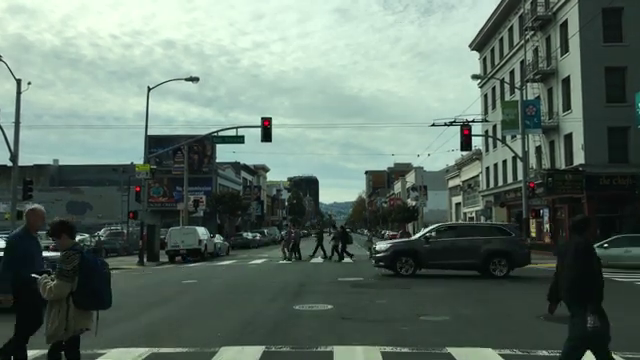

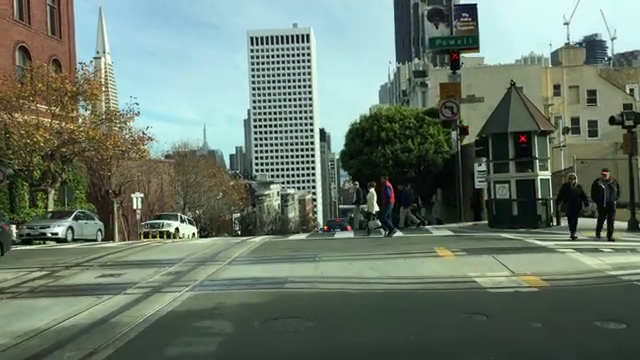

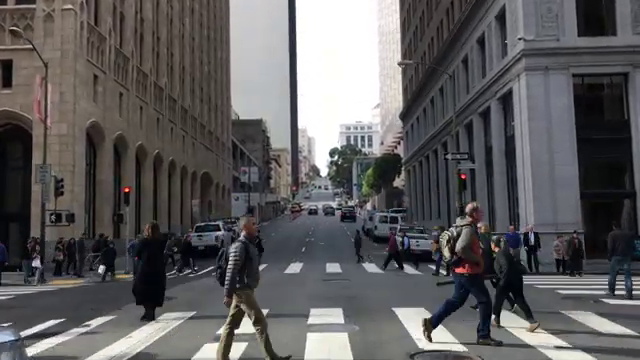

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Search queries</font></b>
#@markdown * Type in text:- "a fire truck", "road works", "people crossing the street"
search_text = 'people crossing the street' #@param {type:'string'}
search_video(search_text)